In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# 성능 평가
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

# 1. 데이터셋

In [2]:
df = pd.read_csv('bigdata/daily-website-visitors.csv')
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [4]:
df.columns = df.columns.str.replace('.', '_', regex=True).str.lower()
df.columns

Index(['row', 'day', 'day_of_week', 'date', 'page_loads', 'unique_visits',
       'first_time_visits', 'returning_visits'],
      dtype='object')

In [5]:
train_size = len(df) - int(len(df)*0.4)

df = df.sample(frac=1, random_state=42)
df['ID'] = range(1, len(df) + 1)
train = df.iloc[:train_size, :]
test = df.iloc[train_size:, :]

print(train.shape, test.shape)

y = 'unique_visits'

X_train = train.drop(columns=y, axis=1)
y_train = train[['ID', y]]

X_test = test.drop(columns=y, axis=1)
y_test = test[['ID', y]]

(1301, 9) (866, 9)


In [6]:
dfX = pd.concat([X_train, X_test], ignore_index=True, axis=0)
dfX.head()

,row,day,day_of_week,date,page_loads,first_time_visits,returning_visits,ID
0,1487,Tuesday,3,10/9/2018,"6,126","3,522",651,1
1,1603,Saturday,7,2/2/2019,"2,864","1,596",306,2
2,1461,Thursday,5,9/13/2018,"4,357","2,325",545,3
3,1135,Sunday,1,10/22/2017,"2,851","1,779",363,4
4,1514,Monday,2,11/5/2018,"6,365","3,609",720,5


In [7]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   row                2167 non-null   int64 
 1   day                2167 non-null   object
 2   day_of_week        2167 non-null   int64 
 3   date               2167 non-null   object
 4   page_loads         2167 non-null   object
 5   first_time_visits  2167 non-null   object
 6   returning_visits   2167 non-null   object
 7   ID                 2167 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 135.6+ KB


In [8]:
dfX['date'] = pd.to_datetime(dfX['date'], format='%m/%d/%Y')

In [9]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   row                2167 non-null   int64         
 1   day                2167 non-null   object        
 2   day_of_week        2167 non-null   int64         
 3   date               2167 non-null   datetime64[ns]
 4   page_loads         2167 non-null   object        
 5   first_time_visits  2167 non-null   object        
 6   returning_visits   2167 non-null   object        
 7   ID                 2167 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 135.6+ KB


In [10]:
dfX.drop(columns='day', axis=1, inplace=True)

In [11]:
col = ['page_loads', 'first_time_visits', 'returning_visits']
dfX[col] = dfX[col].replace(',', '', regex=True).astype(int)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   row                2167 non-null   int64         
 1   day_of_week        2167 non-null   int64         
 2   date               2167 non-null   datetime64[ns]
 3   page_loads         2167 non-null   int32         
 4   first_time_visits  2167 non-null   int32         
 5   returning_visits   2167 non-null   int32         
 6   ID                 2167 non-null   int64         
dtypes: datetime64[ns](1), int32(3), int64(3)
memory usage: 93.2 KB


In [12]:
date = pd.DataFrame()

date['year'] = dfX['date'].dt.year
date['month'] = dfX['date'].dt.month
date['day'] = dfX['date'].dt.day

dfX.drop(columns='date', inplace=True)

dfX_n = pd.concat([dfX, date], axis=1)
dfX_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   row                2167 non-null   int64
 1   day_of_week        2167 non-null   int64
 2   page_loads         2167 non-null   int32
 3   first_time_visits  2167 non-null   int32
 4   returning_visits   2167 non-null   int32
 5   ID                 2167 non-null   int64
 6   year               2167 non-null   int64
 7   month              2167 non-null   int64
 8   day                2167 non-null   int64
dtypes: int32(3), int64(6)
memory usage: 127.1 KB


In [13]:
print(y_train.dtypes)
print(y_test.dtypes)

ID                int64
unique_visits    object
dtype: object
ID                int64
unique_visits    object
dtype: object


In [14]:
y_train['unique_visits'] = y_train['unique_visits'].replace(',', '', regex=True).astype(int)

C:\Users\futur\AppData\Local\Temp\ipykernel_16860\4078436437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['unique_visits'] = y_train['unique_visits'].replace(',', '', regex=True).astype(int)


In [15]:
y_test['unique_visits'] = y_test['unique_visits'].replace(',', '', regex=True).astype(int)

C:\Users\futur\AppData\Local\Temp\ipykernel_16860\3232408644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['unique_visits'] = y_test['unique_visits'].replace(',', '', regex=True).astype(int)


In [16]:
dfXY = pd.merge(dfX_n, y_train)
print(dfXY.shape, dfX_n.shape, y_train.shape)

(1301, 10) (2167, 9) (1301, 2)


In [17]:
dfXY

,row,day_of_week,page_loads,first_time_visits,returning_visits,ID,year,month,day,unique_visits
0,1487,3,6126,3522,651,1,2018,10,9,4173
1,1603,7,2864,1596,306,2,2019,2,2,1902
2,1461,5,4357,2325,545,3,2018,9,13,2870
3,1135,1,2851,1779,363,4,2017,10,22,2142
4,1514,2,6365,3609,720,5,2018,11,5,4329
...,...,...,...,...,...,...,...,...,...,...
1296,1785,7,1849,1096,216,1297,2019,8,3,1312
1297,184,2,5367,3192,579,1298,2015,3,16,3771
1298,138,5,4377,2679,464,1299,2015,1,29,3143
1299,900,4,4936,2822,736,1300,2017,3,1,3558


In [18]:
dfXY.corr()['unique_visits']

row                  0.036363
day_of_week         -0.257838
page_loads           0.988933
first_time_visits    0.996302
returning_visits     0.909094
ID                  -0.052310
year                 0.047526
month               -0.071109
day                 -0.023193
unique_visits        1.000000
Name: unique_visits, dtype: float64

In [19]:
# day_of_week에 따른 unique_visits의 평균을 구해본다.
temp = dfXY.groupby('day_of_week')['unique_visits'].mean()
temp

day_of_week
1    2322.773684
2    3492.336788
3    3485.035928
4    3477.857143
5    3360.644809
6    2645.142077
7    1812.167488
Name: unique_visits, dtype: float64

In [20]:
high_dow = temp[temp>3000].index.values
high_dow

array([2, 3, 4, 5], dtype=int64)

In [21]:
# month에 따른 unique_visits의 평균을 구해본다.
temp = dfXY.groupby('month')['unique_visits'].mean()
temp

month
1     2539.275229
2     3272.737374
3     3214.829268
4     3707.914286
5     3313.684685
6     2608.898148
7     2240.339450
8     2159.236364
9     2605.846847
10    3267.336735
11    3442.318584
12    2685.600000
Name: unique_visits, dtype: float64

In [22]:
high_month = temp[temp > 3000].index.values
high_month

array([ 2,  3,  4,  5, 10, 11], dtype=int64)

In [23]:
# year 따른 unique_visits의 평균을 구해본다.
temp = dfXY.groupby('year')['unique_visits'].mean()
temp

year
2014    2641.530303
2015    2876.165975
2016    3271.789238
2017    2398.257282
2018    3030.347222
2019    2977.344037
2020    3072.404580
Name: unique_visits, dtype: float64

In [24]:
dfX_n['high_dow'] = dfX_n['day_of_week'].isin(high_dow).astype(int)
dfX_n['high_month'] = dfX_n['month'].isin(high_month).astype(int)
dfX_n.head()

,row,day_of_week,page_loads,first_time_visits,returning_visits,ID,year,month,day,high_dow,high_month
0,1487,3,6126,3522,651,1,2018,10,9,1,1
1,1603,7,2864,1596,306,2,2019,2,2,0,1
2,1461,5,4357,2325,545,3,2018,9,13,1,0
3,1135,1,2851,1779,363,4,2017,10,22,0,1
4,1514,2,6365,3609,720,5,2018,11,5,1,1


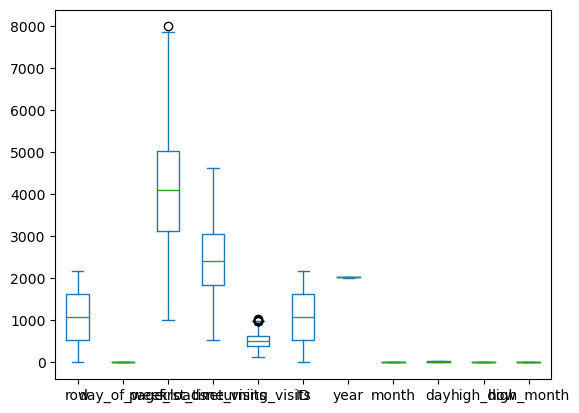

In [25]:
dfX_n.plot(kind='box')
plt.show()

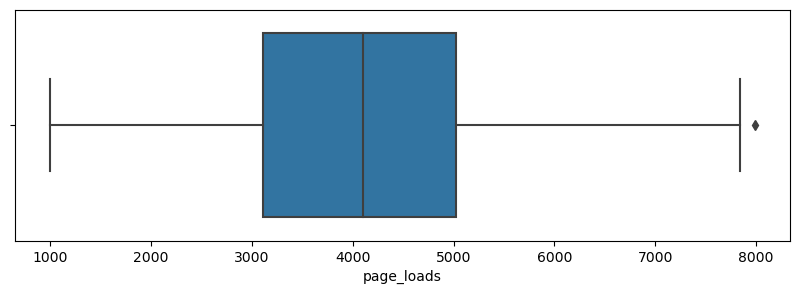

In [26]:
# 이상치 확인
plt.figure(figsize=(10, 3))
sns.boxplot(x='page_loads', data=dfX_n)
plt.show()

In [27]:
dfX_n.columns

Index(['row', 'day_of_week', 'page_loads', 'first_time_visits',
       'returning_visits', 'ID', 'year', 'month', 'day', 'high_dow',
       'high_month'],
      dtype='object')

In [28]:
train_size = len(X_train) # 1301

use_col = ['day_of_week', # 'page_loads', 'first_time_visits',
           'returning_visits', 'year', 'month', 'day', 'high_dow', 'high_month']

dfX_n = dfX_n[use_col]
X_test = dfX_n[train_size:]      # 제출 데이터

X = dfX_n[:train_size]           # 학습 데이터
Y = y_train['unique_visits']     # 학습 데이터의 정답

In [29]:
def modelTrain(model, X, Y, scale=False):
    if scale:
        X = MinMaxScaler().fit_transform(X)

    X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                          test_size=0.3,
                                                          random_state=42)
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 성능 평가
    print('train accuracy:', model.score(X_train, y_train))
    print('valid accuracy:', model.score(X_valid, y_valid))

# 2. 모델 특징 및 사용 방법

## 1) Simple Linear Regression

- $y = \beta_{0} + \beta_{1} x + \epsilon$
- 하나의 X 값을 가지고 Y를 예측하는 것

## 2) Multiple Linear Regression

- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + ...+ \epsilon$

In [30]:
lr = LinearRegression()

In [31]:
# 스케일링 이전
modelTrain(lr, X, Y)

train accuracy: 0.8659986571919714
valid accuracy: 0.8602760739233095


In [32]:
# 스케일링 이후
modelTrain(lr, X, Y, True)

train accuracy: 0.865998657191972
valid accuracy: 0.8602760739233106


In [33]:
print(f'계수: {lr.coef_} \n절편: {lr.intercept_}')

계수: [-169.65306056 3819.97162591  114.05935902  162.19278699  -62.84357492
  292.15929755  396.00083761] 
절편: 957.0931682186031


## 3) Polynomial Regression

- 비선형 데이터 집합을 모델링할 때 사용
- 곡선의 다항식 선을 사용
- X를 다항식으로 변경하여 모델링의 데이터로 사용
- 과대적합이 나타나기 쉬움
- - $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{1}^{2} + \beta_{4} x_{2}^{2} ...+ \epsilon$

In [34]:
poly2 = PolynomialFeatures(degree=2, include_bias=False) # include_bias=True로 할 경우 0차항도 함께 만든다
Xpoly = poly2.fit_transform(X)

In [35]:
# X, Xpoly shape 확인
X.shape, Xpoly.shape

((1301, 7), (1301, 35))

In [36]:
# poly2의 feature_names 확인
poly2.get_feature_names_out()

array(['day_of_week', 'returning_visits', 'year', 'month', 'day',
       'high_dow', 'high_month', 'day_of_week^2',
       'day_of_week returning_visits', 'day_of_week year',
       'day_of_week month', 'day_of_week day', 'day_of_week high_dow',
       'day_of_week high_month', 'returning_visits^2',
       'returning_visits year', 'returning_visits month',
       'returning_visits day', 'returning_visits high_dow',
       'returning_visits high_month', 'year^2', 'year month', 'year day',
       'year high_dow', 'year high_month', 'month^2', 'month day',
       'month high_dow', 'month high_month', 'day^2', 'day high_dow',
       'day high_month', 'high_dow^2', 'high_dow high_month',
       'high_month^2'], dtype=object)

In [37]:
# 스케일링 이전
modelTrain(lr, Xpoly, Y)

train accuracy: 0.9426581792501125
valid accuracy: 0.938445932936455


In [38]:
# 스케일링 이후
modelTrain(lr, Xpoly, Y, True)

train accuracy: 0.9426581792474055
valid accuracy: 0.9384459327913852


## 4) Ridge Regression

- **L2 normalization을 이용**한다.
- 독립변수들 간에 높은 상관관계가 있는 경우, 규제화(regularization)를 적용해 모델의 복잡도를 줄인다.
  - 계수 자체가 크면 규제를 주는 수식을 추가한다.
- 계수값을 0에 가깝게 만들지만 0이 되지는 않는다.
- `alpha` 값 0은 규제를 주지 않겠다는 것이고, 값이 커질수록 규제를 크게 주겠다는 의미이다(coef 값들이 작아진다).
- Ridge Regression은 **변수의 크기가 결과에 큰 영향**을 미치기에 변수를 스케일링 해주어 서로 사이즈가 비슷하도록 만들어주는 작업이 필요할 수 있다. 일반적으로 표준편차를 각 predictors마다 구한 뒤 각 데이터에 나누어준다.
```python
Ridge(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None)
```

In [39]:
# help(Ridge())

In [40]:
Xscaled = MinMaxScaler().fit_transform(X)
poly3 = PolynomialFeatures(degree=3, include_bias=False)
Xpoly3 = poly3.fit_transform(Xscaled)
ridge_coef = pd.DataFrame()

for a in [0, 0.001, 0.01, 0.1, 1, 10]:
    print(f'alpha={a: 7.4f}', end=' ')
    model = Ridge(alpha=a, random_state=0)
    modelTrain(model, Xpoly3, Y)
    ridge_coef[f'alpha_{a}'] = model.coef_

alpha= 0.0000 train accuracy: 0.954572688664983
valid accuracy: 0.945447044119976
alpha= 0.0010 train accuracy: 0.9617735055554687
valid accuracy: 0.9524806368765025
alpha= 0.0100 train accuracy: 0.9610449449685591
valid accuracy: 0.9520910106003174
alpha= 0.1000 train accuracy: 0.9559969857315246
valid accuracy: 0.9483073719852354
alpha= 1.0000 train accuracy: 0.9447441211059966
valid accuracy: 0.9380329493066378
alpha= 10.0000 train accuracy: 0.9087755281965347
valid accuracy: 0.9025857778069197


In [41]:
ridge_coef

,alpha_0,alpha_0.001,alpha_0.01,alpha_0.1,alpha_1,alpha_10
0,1.289239e+03,442.900061,-45.759604,-21.645191,41.084585,46.172583
1,5.059449e+03,5109.640149,4117.641888,2886.993999,1857.450568,818.399650
2,-3.629743e+03,-3519.861144,-2957.140428,-1801.901686,-1255.808102,-438.234556
3,-3.498097e+03,-3381.406736,-2428.886833,-720.846830,-333.728149,-103.197919
4,1.102182e+03,1100.143390,912.870373,437.222338,129.650471,44.023466
...,...,...,...,...,...,...
114,4.260065e+16,-189.980948,-214.292486,-180.541230,-68.548652,-7.541217
115,4.966596e+16,-1.726409,57.515020,111.127747,121.114010,150.454715
116,-5.627164e+16,137.365205,97.538322,46.111738,75.334730,65.908795
117,-4.839976e+15,137.365205,97.538322,46.111738,75.334730,65.908795


In [42]:
ridge_coef.abs().sum()

alpha_0        1.251946e+18
alpha_0.001    1.037316e+05
alpha_0.01     8.223233e+04
alpha_0.1      4.747437e+04
alpha_1        2.486471e+04
alpha_10       1.412572e+04
dtype: float64

## 5) Lasso Regression

- L1 normalization을 이용한다.
- Lasso는 최소제곱법과 매우 유사한, 각 계수 절댓값의 합을 수식에 포함하여 계수의 크기도 함께 최소화하도록 만들었다는 차이가 있다.
- 규제 강도가 커지면 회귀계수가 작아지고 0이 될 수도 있다.
- Lasso를 사용하면 subset selection 효과가 나타난다. Gradient descent를 수행하면서 일부 덜 중요한 계수들이 0으로 수렴하는 결과가 나오기 때문이다.
- Lasso를 적용해보고 모델의 performance가 더 좋아졌다면 내가 가진 데이터의 일부 파라미터를 제거하는 것이 더 좋은 결과를 낼 수 있다는 insight를 가질 수 있다. 이를 통해 다른 subset selection 기법을 적용하는 등 모델의 방향을 잡아볼 수 있다.
```python
Lasso(alpha=1.0, *, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
```

In [43]:
# help(Lasso())

In [44]:
Xscaled = MinMaxScaler().fit_transform(X)
poly3 = PolynomialFeatures(degree=3, include_bias=False)
Xpoly3 = poly3.fit_transform(Xscaled)
lasso_coef = pd.DataFrame()

for a in [0.0001, 0.001, 0.01, 0.1, 1]:
    print(f'alpha={a: 7.4f}', end=' ')
    model = Lasso(alpha=a, max_iter=1000, tol=0.1, random_state=42)
    modelTrain(model, Xpoly3, Y)
    lasso_coef[f'alpha_{a}'] = model.coef_

alpha= 0.0001 train accuracy: 0.9000508044857712
valid accuracy: 0.8897910057205488
alpha= 0.0010 train accuracy: 0.900052124627676
valid accuracy: 0.8897928529965685
alpha= 0.0100 train accuracy: 0.9000642650452407
valid accuracy: 0.8898071500066315
alpha= 0.1000 train accuracy: 0.9001712661933663
valid accuracy: 0.8899276674873068
alpha= 1.0000 train accuracy: 0.8993162405547435
valid accuracy: 0.8891900655082359


In [45]:
lasso_coef

,alpha_0.0001,alpha_0.001,alpha_0.01,alpha_0.1,alpha_1
0,-692.758652,-692.746559,-692.625629,-691.486204,-677.183504
1,4390.424464,4390.379915,4389.934432,4385.600045,4335.902267
2,-3.487329,-3.500160,-3.628478,-5.006294,-13.607278
3,26.187854,26.151233,25.785027,22.030536,-0.000000
4,5.155242,5.165399,5.266961,6.046633,4.435647
...,...,...,...,...,...
114,-0.933623,-0.928031,-0.880616,-0.437653,-0.000000
115,19.215451,19.209777,19.159352,18.614822,23.382226
116,37.780859,37.778336,37.754114,37.357201,33.092979
117,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
lasso_coef.abs().sum()

alpha_0.0001    15708.538146
alpha_0.001     15703.495992
alpha_0.01      15654.345254
alpha_0.1       15160.985066
alpha_1         11643.528054
dtype: float64

## 6) DecisionTreeRegressor

- 분류(classification)와 회귀 분석(regression)에 모두 사용될 수 있기 때문에 CART(Classification And Regression Tree)라고도 한다.
```python
DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
```

In [47]:
# help(DecisionTreeRegressor())

In [48]:
dt = DecisionTreeRegressor()
modelTrain(dt, X, Y)

train accuracy: 1.0
valid accuracy: 0.8902392060641527


In [49]:
modelTrain(dt, X, Y, True)

train accuracy: 1.0
valid accuracy: 0.8898545308512429


이러한 과대적합을 해결하는 방법으로는 다음과 같은 것들이 있다.
- ridge, lasso 등 규제를 적용한 모델 이용
- Ensemble 모델 이용
- 데이터의 크기를 늘리기
- hyperparameter 값을 변경

## 7) RandomForestRegressor

- bagging을 이용한다.
  - bagging: 동일한 모형과 모형 모수를 사용하는 대신 부트스트래핑(bootstrapping)과 유사하게 트레이닝 데이터를 랜덤하게 선택해서 **다수결 모형을 적용**한다.
- RandomForest의 tree들은 평행하게 작동된다. 트리를 생성할 때 트리들끼리 상호 작용하지 않는다.
- 훈련 시간에 다수의 decision tree를 구성하고 개별 트리의 클래스 모드(classification) 또는 평균 예측(regression)인 클래스를 출력하여 작동한다.
```python
RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
```

In [50]:
# help(RandomForestRegressor())

In [51]:
rf = RandomForestRegressor(random_state=42)
modelTrain(rf, X, Y)

train accuracy: 0.991725708337154
valid accuracy: 0.9456827770423774


In [52]:
modelTrain(rf, X, Y, True)

train accuracy: 0.991735515196427
valid accuracy: 0.9455393986428866


## 8) XGB Regression

- 여러 개의 DecisionTree를 조합해서 사용하는 Ensemble 알고리즘
- Greedy-algorithm을 사용해 과적합이 잘 발생하지 않는다.

In [53]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
modelTrain(xgb, X, Y)

train accuracy: 0.9996190488212432
valid accuracy: 0.9655723837285455


In [54]:
modelTrain(xgb, X, Y, True)

train accuracy: 0.9996190488212432
valid accuracy: 0.9651805404554342


## 9) LGBMregressor

- GOSS(Gradient-based One-side Sampling)를 통한 데이터 증폭을 한다.
  - GOSS: 가중치가 작은 개체에 상수를 적용하여 데이터 증폭
- Leaf Wise한 방식을 이용하여 예측 오류 손실을 최소화한다.
- 하지만 Dataset이 충분하지 못하면 과적합이 발생할 확률이 증가한다.
- 정수형으로 인코딩된 변수에 대해 좋은 성능을 제공한다.

In [55]:
lgbm = LGBMRegressor(random_state=42)
modelTrain(lgbm, X, Y)

train accuracy: 0.9903217702977141
valid accuracy: 0.964185332140842


In [56]:
modelTrain(lgbm, X, Y, True)

train accuracy: 0.9903217702977141
valid accuracy: 0.964185332140842


## 10) CatBoostRegressor

- 순서에 따라 모델을 만들고 예측하는 Ordered Boosting이다.
- feature들의 대칭적인 트리 구조를 형성한다.
- XGBoost, LGBM보다 학습 속도가 개선된 모델이다.
- hyperparameter에 따라 성능이 달라지는 민감한 문제를 해결했다.

In [57]:
cat = CatBoostRegressor(iterations=100, random_state=42)
modelTrain(cat, X, Y)

Learning rate set to 0.262246
0:	learn: 792.0761834	total: 134ms	remaining: 13.2s
1:	learn: 657.3601912	total: 135ms	remaining: 6.63s
2:	learn: 554.1313914	total: 137ms	remaining: 4.42s
3:	learn: 479.9151283	total: 139ms	remaining: 3.33s
4:	learn: 431.0099937	total: 140ms	remaining: 2.65s
5:	learn: 385.5215484	total: 141ms	remaining: 2.21s
6:	learn: 359.8480234	total: 143ms	remaining: 1.9s
7:	learn: 329.8983831	total: 144ms	remaining: 1.66s
8:	learn: 305.1855611	total: 146ms	remaining: 1.48s
9:	learn: 283.4857495	total: 148ms	remaining: 1.33s
10:	learn: 270.0612540	total: 149ms	remaining: 1.21s
11:	learn: 262.1253268	total: 150ms	remaining: 1.1s
12:	learn: 254.7467847	total: 152ms	remaining: 1.01s
13:	learn: 247.0944098	total: 153ms	remaining: 941ms
14:	learn: 236.9073433	total: 155ms	remaining: 877ms
15:	learn: 229.6573835	total: 156ms	remaining: 820ms
16:	learn: 224.8724926	total: 158ms	remaining: 772ms
17:	learn: 217.2609889	total: 160ms	remaining: 727ms
18:	learn: 213.9326560	total

In [58]:
modelTrain(cat, X, Y, True)

Learning rate set to 0.262246
0:	learn: 792.0761834	total: 1.66ms	remaining: 164ms
1:	learn: 657.3601912	total: 3.19ms	remaining: 156ms
2:	learn: 554.1313914	total: 4.6ms	remaining: 149ms
3:	learn: 479.9151283	total: 5.96ms	remaining: 143ms
4:	learn: 431.0099937	total: 7.09ms	remaining: 135ms
5:	learn: 385.5215484	total: 8.31ms	remaining: 130ms
6:	learn: 359.8480234	total: 9.54ms	remaining: 127ms
7:	learn: 329.8983831	total: 10.9ms	remaining: 126ms
8:	learn: 305.1855611	total: 12.3ms	remaining: 125ms
9:	learn: 283.4857495	total: 13.7ms	remaining: 123ms
10:	learn: 270.0612540	total: 15ms	remaining: 121ms
11:	learn: 262.1253268	total: 15.9ms	remaining: 117ms
12:	learn: 254.7467847	total: 17.4ms	remaining: 116ms
13:	learn: 247.0944098	total: 18.7ms	remaining: 115ms
14:	learn: 236.9073433	total: 20.2ms	remaining: 114ms
15:	learn: 229.6573835	total: 21.5ms	remaining: 113ms
16:	learn: 224.8724926	total: 22.8ms	remaining: 111ms
17:	learn: 217.2609889	total: 24.3ms	remaining: 111ms
18:	learn: 

# 3.회귀 모델 성능평가

- $R^2$ **score**
  - `model.score(X, y)`
  - `sklearn.metrics.r2_score(y_true, y_pred)`
  - 분산 기반으로 예측 성능을 평가
  - 예측값 분산 / 실제값 분산
- **MAE(Mean Absolute Error)**
   - `sklearn.metrics.mean_absolute_error(y_true, y_pred)`
   - 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균한 것
- **MSE(Mean Squared Error)**
   - `sklearn.metrics.mean_squared_error(y_true, y_pred)`
   - 실제 값과 예측 값의 차이를 제곱해 평균한 것
- **RMSE(Root Mean Squared Error)**
   - sklearn API에 없음
   - MSE에 np.sqrt() 또는 ** 0.5를 사용함
   - MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 것
- **MSLE(Mean Squared Log Error)**
   - `sklearn.metrics.mean_squared_log_error(y_true, y_pred)`
   - MSE에 로그를 적용해준 지표
- **RMSLE(Root Mean Square Log Error)**
   - RMSE에 로그를 적용해준 지표
   - 이상치가 있더라도 변동폭이 크지 않음(이상치에 강건함)
   - 실제값보다 예측값이 작을 때 더 큰 패널티 부여
   - 작게 예측하면 안되는 경우 사용하면 좋음(배달 시간 예측)
   - 실제값, 예측값에 음수가 있으면 안됨(오류 발생)

- R2_socre만 1에 가까울수록 좋으며, MAE, MSE, RMSE, MSLE, RMSLE는 0에 가까울수록 좋다.

In [59]:
def get_scores(model, X, Y):
    pred = model.predict(X)
    
    A = r2_score(Y, pred)
    B = mae(Y, pred)
    C = mse(Y, pred)
    E = np.sqrt(C) # rmse
    
    # msle, rmsle는 음수가 있어서는 안됨
    pred = np.where(pred<0, 0, pred)
    D = msle(Y, pred)
    F = np.sqrt(D) # rmsle
    
    return f'r2: {A:.4} mae: {B:.4} mse: {C:.4} msle: {D:.4} rmse {E:.4} rmsle: {F:.4}'

In [60]:
def modelTrain2(model, X, Y, scale=False):
    if scale:
        X = MinMaxScaler().fit_transform(X)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                         test_size=0.3,
                                                         random_state=42)
    
    model.fit(X_train, y_train)
    
    print(model.__class__)
    print(f'train: {get_scores(model, X_train, y_train)}')
    print(f'valid: {get_scores(model, X_valid, y_valid)}')
    print()
    
    return model

In [61]:
modelTrain2(lr, X, Y)

<class 'sklearn.linear_model._base.LinearRegression'>
train: r2: 0.866 mae: 284.3 mse: 1.285e+05 msle: 0.01976 rmse 358.5 rmsle: 0.1406
valid: r2: 0.8603 mae: 294.5 mse: 1.35e+05 msle: 0.02009 rmse 367.5 rmsle: 0.1417



LinearRegression()

In [62]:
modelTrain2(dt, X, Y)

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
train: r2: 1.0 mae: 0.0 mse: 0.0 msle: 0.0 rmse 0.0 rmsle: 0.0
valid: r2: 0.8894 mae: 242.9 mse: 1.069e+05 msle: 0.01558 rmse 327.0 rmsle: 0.1248



DecisionTreeRegressor()

In [63]:
modelTrain2(rf, X, Y)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
train: r2: 0.9917 mae: 67.56 mse: 7.935e+03 msle: 0.00127 rmse 89.08 rmsle: 0.03564
valid: r2: 0.9457 mae: 180.1 mse: 5.25e+04 msle: 0.008314 rmse 229.1 rmsle: 0.09118



RandomForestRegressor(random_state=42)

In [64]:
modelTrain2(xgb, X, Y)

<class 'xgboost.sklearn.XGBRegressor'>
train: r2: 0.9996 mae: 13.53 mse: 365.3 msle: 5.223e-05 rmse 19.11 rmsle: 0.007227
valid: r2: 0.9656 mae: 141.9 mse: 3.328e+04 msle: 0.005064 rmse 182.4 rmsle: 0.07116



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [65]:
modelTrain2(lgbm, X, Y)

<class 'lightgbm.sklearn.LGBMRegressor'>
train: r2: 0.9903 mae: 73.67 mse: 9.281e+03 msle: 0.001379 rmse 96.34 rmsle: 0.03713
valid: r2: 0.9642 mae: 142.7 mse: 3.462e+04 msle: 0.004691 rmse 186.1 rmsle: 0.06849



LGBMRegressor(random_state=42)

In [66]:
modelTrain2(cat, X, Y)

Learning rate set to 0.262246
0:	learn: 792.0761834	total: 1.67ms	remaining: 165ms
1:	learn: 657.3601912	total: 2.96ms	remaining: 145ms
2:	learn: 554.1313914	total: 4.11ms	remaining: 133ms
3:	learn: 479.9151283	total: 5.45ms	remaining: 131ms
4:	learn: 431.0099937	total: 6.33ms	remaining: 120ms
5:	learn: 385.5215484	total: 7.61ms	remaining: 119ms
6:	learn: 359.8480234	total: 9.01ms	remaining: 120ms
7:	learn: 329.8983831	total: 10.3ms	remaining: 119ms
8:	learn: 305.1855611	total: 11.6ms	remaining: 117ms
9:	learn: 283.4857495	total: 12.9ms	remaining: 116ms
10:	learn: 270.0612540	total: 14.3ms	remaining: 116ms
11:	learn: 262.1253268	total: 15.4ms	remaining: 113ms
12:	learn: 254.7467847	total: 16.6ms	remaining: 111ms
13:	learn: 247.0944098	total: 17.8ms	remaining: 109ms
14:	learn: 236.9073433	total: 19.2ms	remaining: 109ms
15:	learn: 229.6573835	total: 21.1ms	remaining: 111ms
16:	learn: 224.8724926	total: 22.7ms	remaining: 111ms
17:	learn: 217.2609889	total: 24.1ms	remaining: 110ms
18:	lear

In [67]:
# <class 'sklearn.linear_model._base.LinearRegression'>
# train: r2: 0.866 mae: 284.3 mse: 1.285e+05 msle: 0.01976 rmse 358.5 rmsle: 0.1406
# valid: r2: 0.8603 mae: 294.5 mse: 1.35e+05 msle: 0.02009 rmse 367.5 rmsle: 0.1417

# <class 'sklearn.tree._classes.DecisionTreeRegressor'>
# train: r2: 1.0 mae: 0.0 mse: 0.0 msle: 0.0 rmse 0.0 rmsle: 0.0
# valid: r2: 0.8883 mae: 246.8 mse: 1.08e+05 msle: 0.01605 rmse 328.6 rmsle: 0.1267

# <class 'sklearn.ensemble._forest.RandomForestRegressor'>
# train: r2: 0.9917 mae: 67.56 mse: 7.935e+03 msle: 0.00127 rmse 89.08 rmsle: 0.03564
# valid: r2: 0.9457 mae: 180.1 mse: 5.25e+04 msle: 0.008314 rmse 229.1 rmsle: 0.09118

# <class 'xgboost.sklearn.XGBRegressor'>
# train: r2: 0.9996 mae: 13.53 mse: 365.3 msle: 5.223e-05 rmse 19.11 rmsle: 0.007227
# valid: r2: 0.9656 mae: 141.9 mse: 3.328e+04 msle: 0.005064 rmse 182.4 rmsle: 0.07116

# <class 'lightgbm.sklearn.LGBMRegressor'>
# train: r2: 0.9903 mae: 73.67 mse: 9.281e+03 msle: 0.001379 rmse 96.34 rmsle: 0.03713
# valid: r2: 0.9642 mae: 142.7 mse: 3.462e+04 msle: 0.004691 rmse 186.1 rmsle: 0.06849

# <class 'catboost.core.CatBoostRegressor'>
# train: r2: 0.9906 mae: 73.97 mse: 9.035e+03 msle: 0.001257 rmse 95.05 rmsle: 0.03546
# valid: r2: 0.969 mae: 130.9 mse: 2.999e+04 msle: 0.004965 rmse 173.2 rmsle: 0.07047

# 4. 예측값 저장

In [68]:
y_pred = xgb.predict(X_test)
submission = pd.DataFrame({'ID': test['ID'], 'unique_visits': y_pred})
submission.to_csv('submission.csv', index=False)

In [69]:
mse(y_test['unique_visits'], y_pred)

42760.57299319699

In [70]:
mse(y_test['unique_visits'], y_pred) ** 0.5

206.7862978855151

# 참고

- [Ridge regression(능형 회귀) 간단한 설명과 장점](https://modern-manual.tistory.com/entry/Ridge-regression%EB%8A%A5%ED%98%95-%ED%9A%8C%EA%B7%80-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%84%A4%EB%AA%85%EA%B3%BC-%EC%9E%A5%EC%A0%90)
- [Lasso 간단한 설명과 ridge, lasso 비교](https://modern-manual.tistory.com/entry/Lasso-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%84%A4%EB%AA%85%EA%B3%BC-ridge-lasso-%EB%B9%84%EA%B5%90)
- [[ML]Random Forest Regression](https://hororolol.tistory.com/208)
- [[ML] 랜덤 포레스트(Random Forest)란?](https://wooono.tistory.com/115)
- [XGBoost (2) - Parameter 이해와 현업자의 설정 방법](https://dining-developer.tistory.com/4)
- [머신러닝 - 17. 회귀 평가 지표](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-17-%ED%9A%8C%EA%B7%80-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C)